In [2]:
import os
import numpy as np
from PIL import Image
from src.data_handling.mmg_detection_datasets import *
from src.visualizations.plot_image import plot_image_opencv_fit_window
from src.data_augmentation.breast_density.data.resize_image import *
import torch

from src.preprocessing.histogram_standardization import get_hist_stand_landmarks, apply_hist_stand_landmarks



pathologies = None #['mass', 'calcifications', 'suspicious_calcifications', 'architectural_distortion'] # None to select all
status = ['Normal', 'Benign', 'Malignant'] #['Normal'] 
# Resize images keeping aspect ratio

# Call to the OPTIMAM Dataloader
csv_path = '/home/akis-linardos/Datasets/CMMD/info.csv'


In [3]:
csv = pd.read_csv(csv_path, index_col=[0])
# csv=csv.drop(['Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1'],axis=1)
# csv.to_csv(csv_path)


In [4]:
csv

,series_id,Collection,3rd Party Analysis,Data Description URI,patient_id,study_id,Study Description,Study Date,Series Description,manufacturer,...,SOP Class UID,Number of Images,File Size,scan_path,Download Timestamp,status,pathology,laterality,view,image_id
0,1.3.6.1.4.1.14519.5.2.1.1239.1759.292560899611...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,D1-0003,1.3.6.1.4.1.14519.5.2.1.1239.1759.113089024322...,NaN,07-18-2011,NaN,NaN,...,1.2.840.10008.5.1.4.1.1.1.2,2,8.79 MB,CMMD/D1-0003/07-18-2011-NA-NA-25491/1.000000-N...,2022-02-22T14:26:56.454,Benign,calcification,L,CC,0
1,1.3.6.1.4.1.14519.5.2.1.1239.1759.292560899611...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,D1-0003,1.3.6.1.4.1.14519.5.2.1.1239.1759.113089024322...,NaN,07-18-2011,NaN,NaN,...,1.2.840.10008.5.1.4.1.1.1.2,2,8.79 MB,CMMD/D1-0003/07-18-2011-NA-NA-25491/1.000000-N...,2022-02-22T14:26:56.454,Benign,calcification,L,MLO,1
2,1.3.6.1.4.1.14519.5.2.1.1239.1759.623006463861...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,D1-0001,1.3.6.1.4.1.14519.5.2.1.1239.1759.335790956129...,NaN,07-18-2010,NaN,NaN,...,1.2.840.10008.5.1.4.1.1.1.2,2,8.79 MB,CMMD/D1-0001/07-18-2010-NA-NA-79377/1.000000-N...,2022-02-22T14:26:57.31,Benign,calcification,R,CC,2
3,1.3.6.1.4.1.14519.5.2.1.1239.1759.623006463861...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,D1-0001,1.3.6.1.4.1.14519.5.2.1.1239.1759.335790956129...,NaN,07-18-2010,NaN,NaN,...,1.2.840.10008.5.1.4.1.1.1.2,2,8.79 MB,CMMD/D1-0001/07-18-2010-NA-NA-79377/1.000000-N...,2022-02-22T14:26:57.31,Benign,calcification,R,MLO,3
4,1.3.6.1.4.1.14519.5.2.1.1239.1759.411712488433...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,D1-0005,1.3.6.1.4.1.14519.5.2.1.1239.1759.249693111563...,NaN,07-18-2011,NaN,NaN,...,1.2.840.10008.5.1.4.1.1.1.2,2,8.79 MB,CMMD/D1-0005/07-18-2011-NA-NA-52347/1.000000-N...,2022-02-22T14:27:01.533,Benign,calcification,R,CC,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,1.3.6.1.4.1.14519.5.2.1.1239.1759.311460119741...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,D2-0749,1.3.6.1.4.1.14519.5.2.1.1239.1759.134277145908...,NaN,07-17-2012,NaN,NaN,...,1.2.840.10008.5.1.4.1.1.1.2,4,17.57 MB,CMMD/D2-0749/07-17-2012-NA-NA-85032/1.000000-N...,2022-02-22T15:51:25.901,Malignant,mass,L,MLO,5193
5194,1.3.6.1.4.1.14519.5.2.1.1239.1759.242283723072...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,D2-0748,1.3.6.1.4.1.14519.5.2.1.1239.1759.194867387180...,NaN,07-18-2011,NaN,NaN,...,1.2.840.10008.5.1.4.1.1.1.2,4,17.57 MB,CMMD/D2-0748/07-18-2011-NA-NA-50416/1.000000-N...,2022-02-22T15:51:30.918,Malignant,mass,R,CC,5194
5195,1.3.6.1.4.1.14519.5.2.1.1239.1759.242283723072...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,D2-0748,1.3.6.1.4.1.14519.5.2.1.1239.1759.194867387180...,NaN,07-18-2011,NaN,NaN,...,1.2.840.10008.5.1.4.1.1.1.2,4,17.57 MB,CMMD/D2-0748/07-18-2011-NA-NA-50416/1.000000-N...,2022-02-22T15:51:30.918,Malignant,mass,R,MLO,5195
5196,1.3.6.1.4.1.14519.5.2.1.1239.1759.242283723072...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,D2-0748,1.3.6.1.4.1.14519.5.2.1.1239.1759.194867387180...,NaN,07-18-2011,NaN,NaN,...,1.2.840.10008.5.1.4.1.1.1.2,4,17.57 MB,CMMD/D2-0748/07-18-2011-NA-NA-50416/1.000000-N...,2022-02-22T15:51:30.918,Malignant,mass,R,CC,5196


In [9]:
csv['scan_path'][0]

'D1-0003/07-18-2011-NA-NA-25491/1.000000-NA-24283/1-2.dcm'

In [10]:
import pandas as pd
csv_path = '/home/akis-linardos/Datasets/CMMD/info.csv'
csv = pd.read_csv(csv_path, index_col=[0])

csv['image_id'] = range(0,len(csv))
csv['status'][csv['status']=='benign']='Benign'
csv['status'][csv['status']=='malignant']='Malignant'
csv['scan_path']=csv['scan_path'].str.replace('CMMD/' , '')
# csv['ACR']=[0]*len(csv)
# csv['BIRADS']=[1]*len(csv)
csv=csv.rename(columns={'client_id':'patient_id', 'image_filepath':'scan_path'})
csv.to_csv(csv_path)

dataset_path = '/home/akis-linardos/Datasets/CMMD'
cmmd_clients = CMMDDataset(csv_path, dataset_path, load_max=-1)
ROOT_DATA_PATH = '/home/akis-linardos/Datasets'
# Call to the OPTIMAM Dataloader

for status in ['Normal', 'Benign', 'Malignant']:
    clients_selected = cmmd_clients.get_clients_by_status(status)
    print(f'Total clients selected by status ({status}): {len(clients_selected)}')

/home/akis-linardos/BFP/docker/fl_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/akis-linardos/BFP/docker/fl_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Total clients selected by status (Normal): 0
Total clients selected by status (Benign): 479
Total clients selected by status (Malignant): 1295


# Data Loader playground:

In [6]:
subjects = CMMDDataset(csv_path, dataset_path, load_max=-1)
images_benign, images_normal, images_malignant = [], [], []
for c in subjects:
    for imlist, status in zip([images_normal, images_benign, images_malignant], ['Normal', 'Benign', 'Malignant']):
        client_images_by_status = c.get_images_by_status(status=[status])
        for image in client_images_by_status:
            imlist.append(image)
# images_benign, images_normal, images_malignant = [], [], []
# Balance the dataset
balance_to_min_index = min([len(images_benign), len(images_malignant)])
images_benign = images_benign[:balance_to_min_index]
images_malignant = images_malignant[:balance_to_min_index]
total_images = images_benign + images_malignant
for ims, status in zip([images_benign, images_malignant], ['benign', 'malignant']):
    print(f'Total images selected by status ({status}): {len(ims)}')

Total images selected by status (benign): 1108
Total images selected by status (malignant): 1108


In [7]:
import random
random.shuffle(total_images) 

# Data Split
training_images = total_images[:int(0.8*len(total_images))]
validation_images = total_images[int(0.8*len(total_images)):]
test_images = total_images[int(0.8*len(total_images)):]

images = validation_images

In [8]:
import pydicom as dicom

image=images[0]

if image.status=='Malignant' or image.status=='Interval Cancer':
    label = np.single(1)
elif image.status=='Benign' or image.status=='Normal':
    label = np.single(0)
# label = np.single(1) if image.status=='Malignant' else np.single(0)
# status = image.status # ['Benign', 'Malignant', 'Interval Cancer', 'Normal']
manufacturer = image.manufacturer # ['HOLOGIC, Inc.', 'Philips Digital Mammography Sweden AB', 'GE MEDICAL SYSTEMS', 'Philips Medical Systems', 'SIEMENS']
# view = image.view # MLO_VIEW = ['MLO','LMLO','RMLO', 'LMO', 'ML'] CC_VIEW = ['CC','LCC','RCC', 'XCCL', 'XCCM']
# laterality = image.laterality # L R
if ".dcm" in image.path:
    # If this doesn't work. Check Lidia's https://gitlab.com/eucanimage/BreastCancer/-/blob/master/src/preprocessing/mmg_utils.py
    img_dcm = dicom.dcmread(image.path)
    img_np = img_dcm.pixel_array
else:
    img_pil = Image.open(image.path).convert('RGB')
    img_np = np.array(img_pil)

In [26]:
img_np.shape

(2294, 1914)

(2294, 1914)


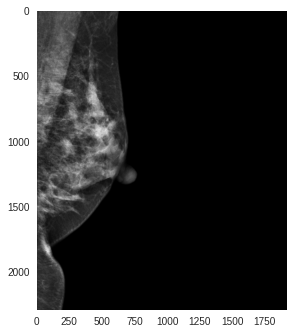

In [46]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.imshow(img_np, cmap='gray')
plt.grid(False)
print(img_np.shape)

In [47]:
def crop_new(arr):

    mask = arr != 0
    n = mask.ndim
    dims = range(n)
    slices = [None]*n

    for i in dims:
        mask_i = mask.any(tuple([*dims[:i], *dims[i+1:]]))
        slices[i] = (mask_i.argmax(), len(mask_i) - mask_i[::-1].argmax())

    return arr[[slice(*s) for s in slices]]

In [50]:
img_np = crop_new(img_np)

/home/akis-linardos/BFP/docker/fl_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':


In [51]:
rescale_height = 224
rescale_width = 224
scale_size = (rescale_height, rescale_width)
# CROP!
img_np = np.uint8(img_np) if img_np.dtype != np.uint8 else img_np.copy()
rescaled_img, scale_factor = imrescale(img_np, scale_size, return_scale=True, backend='pillow')
image = rescaled_img

In [52]:
image.shape

(224, 75)

In [55]:
from pathlib import Path
HOME_PATH = Path.home()
LANDMARKS = os.environ['landmarks']# CONFIG['paths']['landmarks']
image = torch.from_numpy(image)

In [56]:
landmarks_values = torch.load(HOME_PATH / LANDMARKS)
apply_hist_stand_landmarks(image, landmarks_values)

array([[35.93587 , 35.93587 , 40.56335 , ..., 17.56217 , 17.56217 ,
        17.56217 ],
       [37.671177, 37.671177, 43.911335, ..., 17.56217 , 17.56217 ,
        17.56217 ],
       [37.671177, 37.09274 , 41.83417 , ..., 17.56217 , 17.56217 ,
        17.56217 ],
       ...,
       [28.90854 , 30.25528 , 32.94876 , ..., 17.56217 , 17.56217 ,
        17.56217 ],
       [30.25528 , 30.92865 , 32.27539 , ..., 17.56217 , 17.56217 ,
        17.56217 ],
       [30.25528 , 31.60202 , 32.27539 , ..., 17.56217 , 17.56217 ,
        17.56217 ]], dtype=float32)

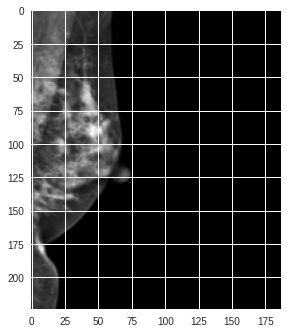

In [23]:
plt.imshow(image, cmap='gray')

In [25]:
image.shape

(224, 187)

In [40]:
a = np.zeros((30, 30, 30, 20),dtype=np.uint8)
a[2:-2, 2:-2, 2:-2, 2:-2] = np.random.randint(0,255,(26,26,26,16),dtype=np.uint8)

/home/akis-linardos/BFP/docker/fl_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':


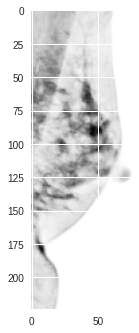

In [44]:
plt.imshow(crop_new(image))

In [45]:
crop_new(image).shape

/home/akis-linardos/BFP/docker/fl_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':


(224, 76)

In [29]:
paddedimg = torch.zeros(224,187)
h,w = image.shape
paddedimg[-h:,-w:]=image

TypeError: can't assign a numpy.ndarray to a torch.FloatTensor

In [38]:
images_benign[0]

In [16]:
479+1295

1774

In [41]:
cmmd_clients.total_images()

5198

In [15]:
images_benign, images_normal, images_malignant = [], [], []
for c in cmmd_clients:
    for lists, status in zip([images_normal, images_benign, images_malignant], ['Normal', 'Benign', 'Malignant']):
        client_images_by_status = c.get_images_by_status(status=[status])
        for image in client_images_by_status:
            lists.append(image)
count_dict = {'Normal':0,'Benign':0, 'Malignant':0}      
for l, status in zip([images_normal, images_benign, images_malignant], ['Normal', 'Benign', 'Malignant']):
    print(f'Printing status {status}:')
    for i in l:
        # print(i.status)
        count_dict[status]+=1
    print(count_dict[status])

Printing status Normal:
0
Printing status Benign:
1108
Printing status Malignant:
4090
